In [12]:
%pip install diffusers transformers

# UNSPLASH + SB + SAM Setup

In [22]:
import torch
import matplotlib.pyplot as plt
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid
from transformers import SamModel, SamProcessor
from PIL import Image
import numpy as np

image_w = 400
unsplash_image = f"https://images.unsplash.com/photo-1727884747982-4532ed1cb541?q=80&w={image_w}&auto=format&fit=crop"
if (torch.cuda.is_available()):
    device = "cuda"
else:
    device = "cpu"

## SAM

Inspired by:
- https://github.com/huggingface/notebooks/blob/main/examples/segment_anything.ipynb
- https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
- https://colab.research.google.com/drive/1B7L4cork9UFTtIB02EntjiZRLYuqJS2b#scrollTo=LtZghyHoJabf

In [15]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_masks_on_image(raw_image, masks, scores):
  if len(masks.shape) == 4:
    masks = masks.squeeze()
  if scores.shape[0] == 1:
    scores = scores.squeeze()

  nb_predictions = scores.shape[-1]
  fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

  for i, (mask, score) in enumerate(zip(masks, scores)):
    mask = mask.cpu().detach()
    axes[i].imshow(np.array(raw_image))
    show_mask(mask, axes[i])
    axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
    axes[i].axis("off")
  plt.show()

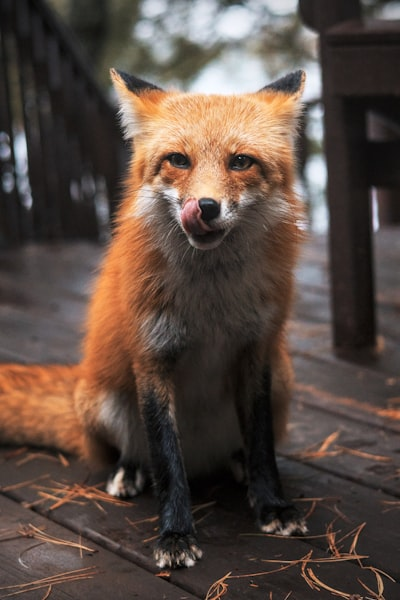

In [16]:
image = load_image(unsplash_image)
image

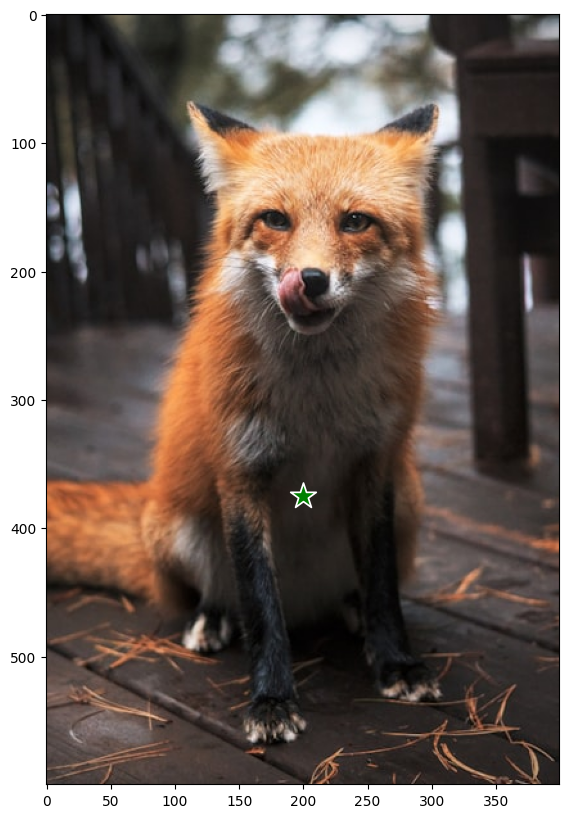

In [17]:
# Setting up a point on the image to indicate to SAM what we want to segment.
input_points = [[[image_w / 2, 375]]]
show_points_on_image(image, input_points[0])

In [23]:
sam_model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In order to avoid computing multiple times the same image embeddings, we will compute it only once, and use these embeddings to directly feed them to the model for faster inference

In [24]:
inputs = sam_processor(image, return_tensors="pt").to(device)
image_embeddings = sam_model.get_image_embeddings(inputs["pixel_values"])

In [25]:
inputs = sam_processor(image, input_points=input_points, return_tensors="pt").to(device)
# pop the pixel_values as they are not neded
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})
with torch.no_grad():
    outputs = sam_model(**inputs)

masks_ = sam_processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores

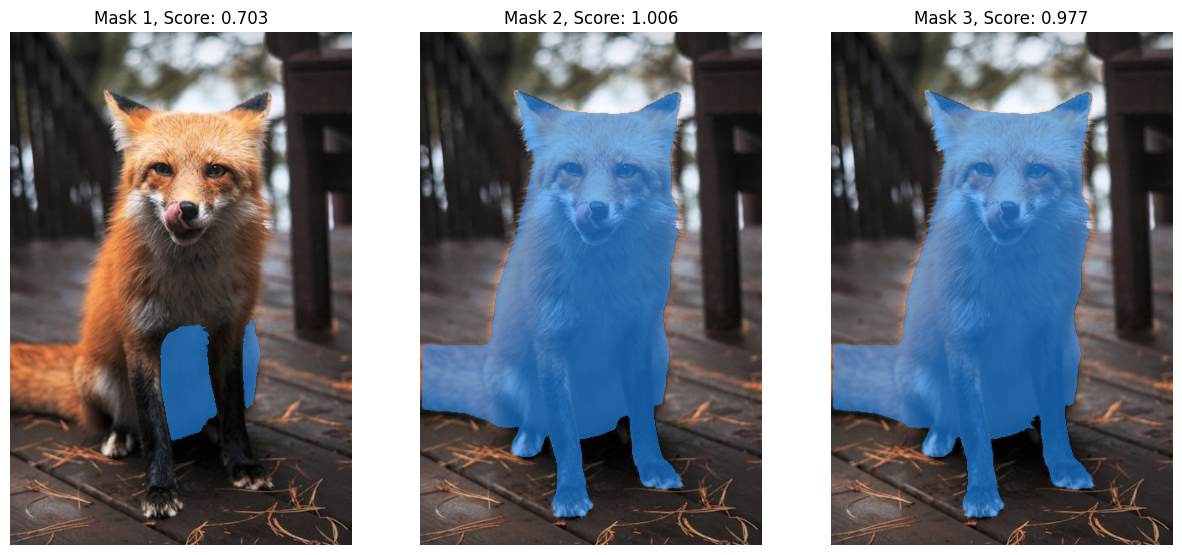

In [26]:
show_masks_on_image(image, masks_[0], scores)

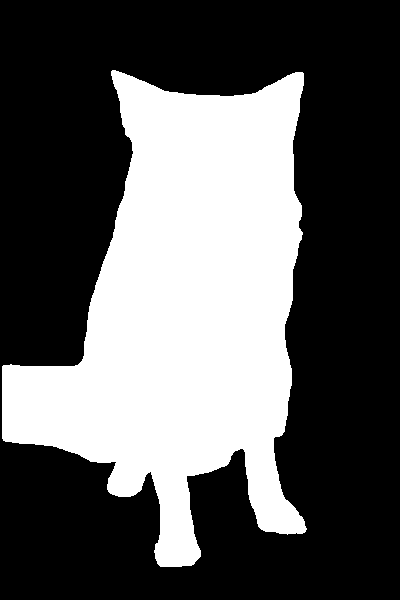

In [27]:
# By default SAM produces "multi masks" but we only care about one.
masks = masks_[0][0]
max_score_index = torch.argmax(scores).item()
best_mask = masks[max_score_index]

binary_mask = (best_mask > 0.5).float()
binary_mask_8bit = (binary_mask * 255).byte()

mask_image = Image.fromarray(binary_mask_8bit.cpu().numpy(), mode='L')
mask_image = mask_image.resize(image.size)

mask_image

In [ ]:
pipeline = AutoPipelineForInpainting.from_pretrained(
    "kandinsky-community/kandinsky-2-2-decoder-inpaint", torch_dtype=torch.float16
)
if (device == "cuda"):
  pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

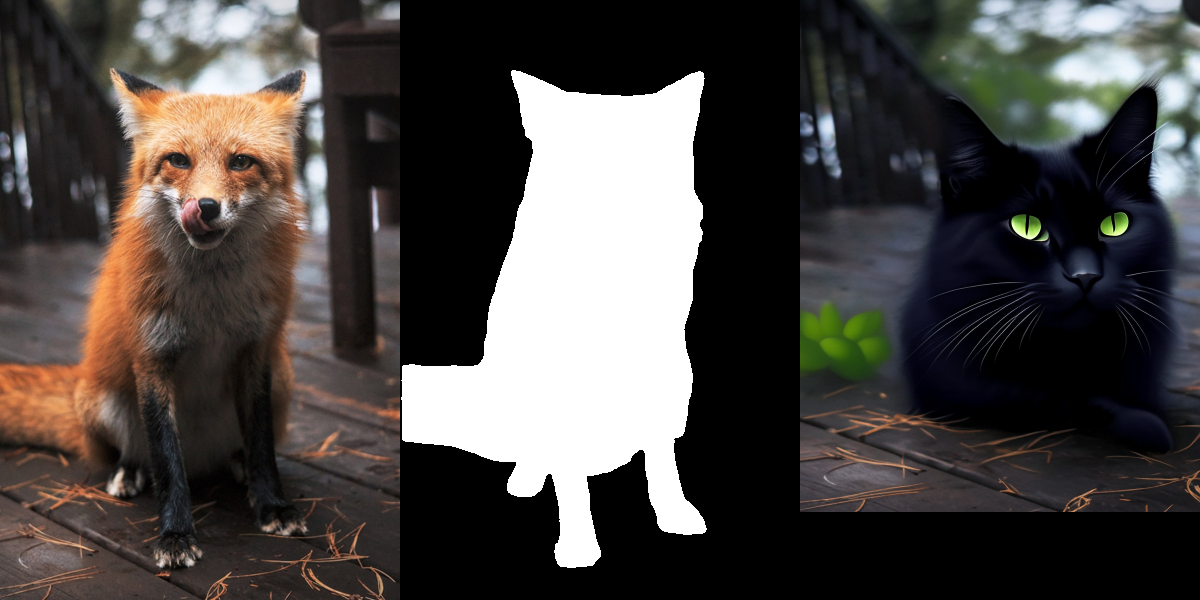

In [13]:
prompt = "a black cat cute, adorable, highly detailed, photo realistic"
negative_prompt = "bad anatomy, deformed, ugly, disfigured"
result = pipeline(prompt=prompt, negative_prompt=negative_prompt, image=image, mask_image=mask_image).images[0]
make_image_grid([image, mask_image, result], rows=1, cols=3)